# 1. Measure and improve

How do we know that search engine's quality improved (or at least haven't deteriorated) because of our changes?

All we need is a way to ***evaluate*** our search engine. We will consider some of the popular evaluation techniques:

1. Mean Average Precision
2. 11-Point Interpolated Average
3. Normalized Discounted Cumulative Gain (NDCG)
4. pFound

<!--We will apply them in the context of ranking with language models and will compare two ways of smoothing: additive and Jelinek-Mercer smoothing.
-->

It's best to go through the [book](https://nlp.stanford.edu/IR-book/pdf/irbookonlinereading.pdf) *chapter 8*, concretely, *8.4* to understand the key concepts of this lab. Here we will only present some excerpts from it.

## 1.1. [10] Mean Average Precision

The most standard metric among the TREC community is *Mean Average Precision* *(MAP)*, which provides a single-figure measure of quality across recall levels. Among evaluation measures, MAP has been shown to have especially good discrimination and stability. For a single information need, Average Precision is the average of the precision value obtained for the set of top $k$ documents existing
after each relevant document is retrieved, and this value is then averaged over information needs (queries). 
Assume we have a bucket $Q$ of queries $q_j\in Q$.
If the set of **relevant documents** for an information need (query) $q_j$ is {d<sub>1</sub>, . . . d<sub>m<sub>j</sub></sub>} and R<sub>jk</sub> is the set of ranked retrieval results from the top result until you get to document d<sub>k</sub>, then

![](https://i.imgur.com/EGQMHVq.png)

Implement this metric in the `mean_avg_precision` function.

**NB** Don't make the name of [the metric confuse you](https://towardsdatascience.com/breaking-down-mean-average-precision-map-ae462f623a52). *Average Precision* is the term, which corresponds to the area under precision-recall curve. It's computation is tricky. We suggest to start with implementing [$AveP$](https://en.wikipedia.org/wiki/Evaluation_measures_(information_retrieval)#Average_precision).

In [19]:
import numpy as np

# this function will used across the notebook
def is_relevant(document_id: int, q_relevance: list[int]) -> int:
  """Determines whether the document is relevant. """
  for qr in q_relevance:
    if qr[0] == document_id:
      return 1
  return 0

def avr_prec_per_query(query_result, query_relevance):
  """calculates the average precision for a single query"""

  result = 0
  num_relevant_docs = 0
  for k in range(len(query_result)):
    num_relevant_docs += is_relevant(query_result[k], query_relevance)
    precision = num_relevant_docs / (k+1)
    result += precision * is_relevant(query_result[k], query_relevance)
  return result/num_relevant_docs if num_relevant_docs != 0 else 0

def mean_avg_precision(search_results, relevance):
  """Calculate the mean average precision: The mean of average precision for each query"""
  return np.mean([avr_prec_per_query(search_results[i], relevance[i + 1]) for i in range(len(search_results))])



### 1.1.1. Tests

In [20]:
import numpy as np

test_relevance = {1: [(9, 1), (1, 2), (8, 3)], 2: [(5, 1), (9, 2), (6, 3)], 
                  3: [(9, 1), (4, 2), (6, 3)], 4: [(10, 1), (4, 2), (7, 3)], 
                  5: [(4, 1), (2, 2), (8, 3)], 6: [(2, 1), (9, 2), (4, 3)], 
                  7: [(1, 1), (2, 2), (3, 3)], 8: [(3, 1), (2, 2), (6, 3)], 
                  9: [(1, 1), (4, 2), (3, 3)], 10: [(10, 1), (7, 2), (8, 3)]}
test_results = [[4, 5, 3, 6, 1, 2, 8, 9, 10, 7], [7, 5, 6, 3, 1, 8, 9, 4, 2, 10], 
                [8, 3, 4, 5, 9, 6, 1, 10, 2, 7], [4, 5, 7, 3, 6, 10, 1, 9, 2, 8], 
                [4, 8, 3, 5, 6, 7, 2, 1, 10, 9], [9, 7, 6, 5, 2, 4, 10, 1, 3, 8], 
                [3, 1, 5, 2, 10, 6, 7, 9, 8, 4], [9, 2, 4, 10, 8, 3, 7, 6, 1, 5], 
                [3, 4, 6, 1, 5, 10, 7, 2, 8, 9], [8, 10, 4, 1, 3, 7, 5, 6, 9, 2]]


map_test = mean_avg_precision(test_results, test_relevance)
print("map_test", map_test)
assert np.isclose(map_test, 0.646, atol=1e-03)
assert mean_avg_precision(test_results[:5], test_relevance) > mean_avg_precision(test_results[5:10], test_relevance)

map_test 0.6464285714285714


## 1.2. [15] 11-Point Interpolated Average

In a ranked retrieval context, appropriate sets of retrieved documents are naturally given by the top k retrieved documents. For each such set, precision and recall values can be plotted to give a precision-recall curve, such as this one (blue line):

![](https://i.imgur.com/QnvDLAJ.png)

Precision-recall curves have a distinctive saw-tooth shape: if the *(k + 1)<sup>th</sup>* document retrieved is nonrelevant then recall is the same as for the top k documents, but precision has dropped. If it is relevant, then both precision and recall increase, and the curve jags up and to the right.

It is often useful to remove these jiggles and the standard way to do this is with an *interpolated precision*: the interpolated precision *p<sub>interp</sub>* at a certain recall level *r* is defined as the highest precision found for any recall level *r′* ≥ *r*:

![](https://i.imgur.com/GMl2rQw.png)

The justification is that almost anyone would be prepared to look at a few more documents if it would increase the percentage of the viewed set that were relevant (that is, if the precision of the larger set is higher). Interpolated precision is shown by a red line in the figure above.

Examining this information for a single query may be useful, but usually we are more interested in a composite metrics, which will score over all test queries. The traditional way of doing this is the *11-point interpolated average*. For each information need, the interpolated precision is measured at the 11 recall levels of 0.0, 0.1, 0.2, . . . , 1.0. Then we average interpolated precision over all queries in the test collection and plot, like here:

![](https://i.imgur.com/6wDmtp2.png)


Plotting a number of such graphs for different versions of search engine on the same plot helps to compare their performance.

You need to incorporate this logic into `eleven_points_interpolated_avg` function. Break it down to subfuctions as it seems necessary to you.

In [33]:
import matplotlib.pyplot as plt


def precision_points(query_result, query_relevance):
  """Return the precision and recall for the given query at each result position"""
  result = []
  recalls = []
  num_relevant_docs = 0
  for k in range(len(query_result)):
    num_relevant_docs += is_relevant(query_result[k], query_relevance)
    precision = num_relevant_docs / (k+1)
    result += [precision * is_relevant(query_result[k], query_relevance)]
    recalls += [num_relevant_docs/len(query_relevance)]
  return result, recalls

def eleven_points_interpolated_avg_query(query_results, query_relevance):
  """
    Returns the 11-P interpolated average precision for a single query: a list of 11 elements
  """
  precision, recall = precision_points(query_results, query_relevance)
  result = []
  current_recall = 0
  current_index  = 0

  for i in range(len(precision)):
    while recall[i] - current_recall > 0.1:
      interpolated_precision = max(precision[current_index:])
      result.append(interpolated_precision)
      current_recall += 0.1
      current_index = i
  while len(result) < 11:
    result.append(max(precision[current_index:]))
  return result


def eleven_points_interpolated_avg(search_results, relevance, plot=True):
  """Returns the 11-P interpolated average precision over all queries
  :return: List of size 11
  """
  query_results = [eleven_points_interpolated_avg_query(search_results[i],relevance[i + 1]) for i in range(len(search_results))]
  result =  [np.mean([query_results[i][k] for i in range(len(search_results))]) for k in range(11)]
  print(result)
  if plot:
    plt.plot(np.linspace(0, 1, 11), result)
    plt.scatter(np.linspace(0, 1, 11), result)
    # plt.yticks(list(np.linspace(0, 1, 11)))
  return result

### 1.2.1.Tests

[0.8041666666666666, 0.8041666666666666, 0.8041666666666666, 0.8041666666666666, 0.7083333333333333, 0.7083333333333333, 0.7083333333333333, 0.5107142857142858, 0.5107142857142858, 0.5107142857142858, 0.5107142857142858]


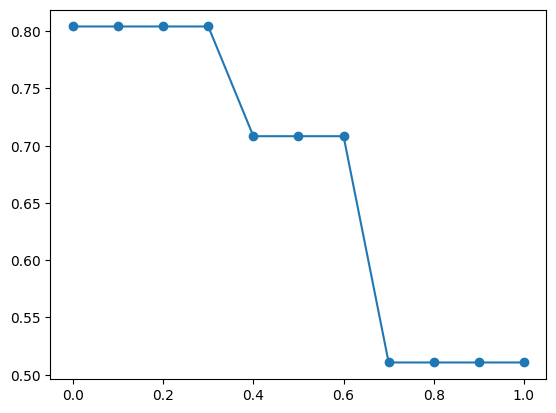

In [34]:
eleven_test = eleven_points_interpolated_avg(test_results, test_relevance, plot=True)
assert all(eleven_test[k] >= eleven_test[k+1] for k in range(len(eleven_test)-1))

## 1.3. [10] Normalized Discounted Cumulative Gain

NDCG metric is designed for situations of non-binary notions of relevance. It is evaluated over some number $k$ of top search results (in our case we will evaluate over the whole dataset, since it is small). 

For a set of queries $Q$, let $R(j,d)$ be the relevance score assessors gave to document $d$ for query $j$. Then,

![](https://i.imgur.com/LLogCYa.png)

where $Z_{kj}$ is a normalization factor calculated to make it so that a perfect ranking’s NDCG at $k$ for query $j$ is 1. In other words, we divide calculated DCG score by ideal DCG score. 

Implement this metric in `NDCG` function.

In [23]:
import math 
import math 

def relevance_score(document_id, query_relevance):
    """Returns the relevance score of the document"""
    for i in query_relevance:
      if i[0] == document_id:
        return 5 - i[1]
    return 0

def DCG_query(query_results, query_relevance):
    """Returns the DCG score of one single query """
    return np.sum([(2**relevance_score(query_results[k], query_relevance) -1) / math.log2(2+k) for k in range(len(query_results))])

def IDCG_query(query_results, query_relevance):
    """Returns the IDCG for one query"""
    return DCG_query(
        sorted(query_results, key=lambda x: relevance_score(x, query_relevance), reverse=True),
        query_relevance
    )

def NDCG_query(query_results, query_relevance):
    """returns the NDCG per query"""
    dcg = DCG_query(query_results, query_relevance)
    idcg = IDCG_query(query_results, query_relevance)
    return dcg / idcg if idcg != 0 else 0

def NDCG(search_results, relevance):
    """Returns the NDCG mean over all queries"""
    return np.mean([NDCG_query(search_results[i], relevance[i + 1]) for i in range(len(search_results))])


### 1.3.1. Tests

In [24]:
ndcg_test = NDCG(test_results, test_relevance)
print("ndcg_test", ndcg_test)
assert np.isclose(ndcg_test, 0.640, atol=1e-03)
assert NDCG(test_results[:5], test_relevance) < NDCG(test_results[5:10], test_relevance)

ndcg_test 0.6409675295633275


## 1.4. [15] pFound ## 
**pFound** -- ranking metric invented in [Yandex](http://romip.ru/romip2009/15_yandex.pdf). This metric models user behaviour when looking at the search engine representation page (SERP). Metric assumes a user is inspecting a list from the top to the bottom. There are 2 global parameters, controlling behaviour:
- `pBreak` -- how probable, that the user will become tired and just quit at this position (`0.15` by default).
- `pRel` -- how probable the user will click the document if this document is relevant (`0.4` by default for a relevan document, `0` is given to irrelevant).

Then, to compute pFound for the exact page we do:

$pLook_i = pLook_{i-1}*(1 - pBreak)*(1 - pRel_{i-1})$

$pFound = \sum_{i=1}^{N}pLook_i*pRel_i$

Implement `pFound` below.

In [25]:

# Constants for further use 
PBREAK = 0.15
PREL = 0.4

def pRel(document_id, query_relevance):
    "Calculate the pRel value of the document"
    return PREL * is_relevant(document_id, query_relevance)

def pFound_query(query_result, query_relevance):
    """Calculate the pFound value for a single query """
    """Returns the pFound value for one query"""
    result = 0
    pLook = 1
    last_pRel = 0
    for qr in query_result:
      last_pRel =  pRel(qr, query_relevance)
      result += pLook * last_pRel
      pLook = pLook * (1 - PBREAK) * (1 - last_pRel)
    return result

def pFound(search_results, relevance):
    """Returns the mean pFound over all given queries"""
    return np.mean([pFound_query(search_results[i], relevance[i + 1]) for i in range(len(search_results))])

### 1.4.1. Tests

In [26]:
pFound_test = pFound(test_results, test_relevance)
print("pFound", pFound_test)
assert np.isclose(pFound_test, 0.582, atol=1e-03)
assert pFound(test_results[:5], test_relevance) > pFound(test_results[5:10], test_relevance)

pFound 0.5821558180674999
